# Import Needed Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import os
import shutil
import PIL
import cv2
import random
import dlib
from scipy import ndimage
from datetime import datetime

## Set things up

In [2]:
RANDOM_SEED = 123

# Check Database
Do we have any problems?

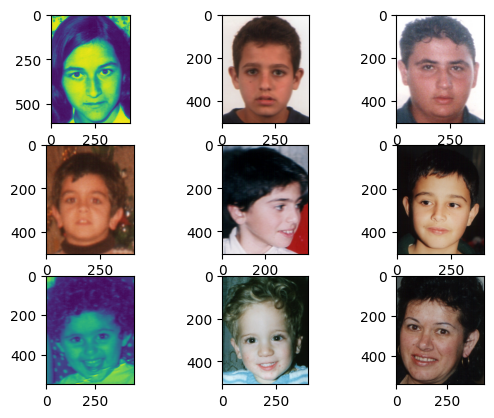

In [3]:
# define location of datasets
fg_net = 'datasets/FGNet/'

#plot 9 random images
fg_list = []


for (dirp, dirn, filen) in os.walk(fg_net):
    fg_list.extend(random.sample(filen,9))
    break

break_iter = 0
for iter,file in enumerate(fg_list,9):
    plt.subplot(330 + 1 + (iter % 9))
    # define filename
    # load image pixels
    image = plt.imread(fg_net+file)
    # plot raw pixel data
    plt.imshow(image)
    if break_iter >= 9:
        break
# show the figure
plt.show()

# Organise the Images

## Bring in Function to Align Face and Crop
Using the function liam wrote to ensure consistant data

In [4]:
# Initialize the Dlib face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
failed_to_crop = 0
no_face_detected = 0


# Function to detect and align faces in an image
def align_and_crop_face(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray)

    # Check if a face is detected
    if len(faces) > 0:
        # Assume there's only one face in the image for simplicity
        face = faces[0]

        # Get the facial landmarks for face alignment
        shape = predictor(gray, face)

        # Define the coordinates for the eyes
        left_eye = shape.part(36)  # Left eye
        right_eye = shape.part(45)  # Right eye

        # Calculate the angle for rotation (to make eyes horizontal)
        angle = np.arctan2(right_eye.y - left_eye.y, right_eye.x - left_eye.x)
        angle = np.degrees(angle)

        # Rotate and crop the face
        rotated_image = ndimage.rotate(image, angle, mode='nearest')
        cropped_face = rotated_image[face.top():face.bottom(), face.left():face.right()]

        # Check if the cropped face is not empty
        if not cropped_face.size == 0:
            # Save the aligned and cropped face
            cv2.imwrite(output_path, cropped_face)
        else:
            global failed_to_crop
            failed_to_crop += 1
    else:
        global no_face_detected
        no_face_detected += 1

In [5]:
#%%script false

# clear the directory if it exists, it it doesn't create it
dataset_home = 'fg_test_data' + os.sep 
cropped_data = "fg_test_data_cropped" + os.sep 


if os.path.exists(dataset_home):
    # Remove all files in the directory
    for filename in os.listdir(dataset_home):
        file_path = os.path.join(dataset_home, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Error cleaning {file_path}: {e}")
else:
        print(f"The directory {dataset_home} does not exist.")
        
# Make Directories for Age

for i in range (0,117): #max range of both the data sets
    os.makedirs(os.path.join(dataset_home,str(i)), exist_ok = True)
    os.makedirs(os.path.join(cropped_data,str(i)), exist_ok = True)

# Bring in both data sets and split them, 
# utk_face filename starts with one, fg_net starts with 2 
# This has been done for potential debugging
test_ratio = 0.1 

for iter,file in enumerate(os.listdir(fg_net)):
    src = os.path.join(fg_net, file)
    
    # break down the file name to get age data
    string_lab = file.split("A")
    string_lab2 = string_lab[1].split(".")[0]
    string_lab3 = string_lab2.replace("a","")
    age = int(string_lab3.replace("b",""))
     
    uncr_source = os.path.join(dataset_home,str(age))
    cr_source = os.path.join(cropped_data,str(age))
    file_name = "2_"+ str(age) +"_i_" + str(iter)+".jpg" 
    
    photo = tf.keras.utils.load_img(src, target_size=(200, 200))
    photo.save(os.path.join(uncr_source,file_name))  
    
    align_and_crop_face(os.path.join(uncr_source,file_name),os.path.join(cr_source,file_name))   
    
print(f"{failed_to_crop} Images failed to crop")
print(f"{no_face_detected} Images without a detectable face")

24 Images failed to crop
131 Images without a detectable face


# Bring into Keras
Bring it in as a keras package so it can be used by keras, bring in the datasize

In [6]:
IMG_SIZE=64     #Img size
ROWS = 256      #Img size
COLS = 256      #Img size
CHANNELS = 3    #RGB
batch_size=64   #What was shown as a good number for back propogation in AlexNet


test_cropped_ds = tf.keras.preprocessing.image_dataset_from_directory(
  cropped_data,
  validation_split=0, 
  seed=RANDOM_SEED,
  image_size=(ROWS, COLS),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_home,
  validation_split=0, 
  seed=RANDOM_SEED,
  image_size=(ROWS, COLS),
  batch_size=batch_size)

Found 847 files belonging to 117 classes.
Found 1002 files belonging to 117 classes.


## Check that the data loaded correctly

117


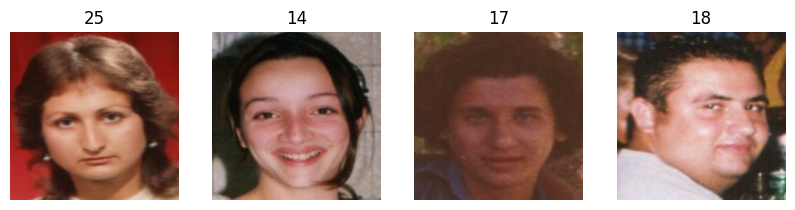

In [7]:
# Need the directories for the number
test_dir_names = list(os.listdir(dataset_home))
print(len(test_dir_names))

# Needed for propper labeling
class_names = test_ds.class_names

# Check if it works
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1,4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])  # Has weird internal organising, class names needed
        plt.axis("off")

In [8]:
#Check the labeling
print("Test shape: {}".format(images[1].shape))
print(class_names)

Test shape: (256, 256, 3)
['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [9]:
# Create a new model instance
model = tf.keras.models.load_model('savedmodel')

model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use mean squared error for regression
              metrics=['mean_absolute_error']) 


test_loss, test_accuracy = model.evaluate(test_cropped_ds)
print(f"Cropped Mean Absolute Error (Lower Better): {test_accuracy:.2f}")
print(f"Cropped Test Loss: {test_loss:.4f}")

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Uncropped Mean Absolute Error (Lower Better): {test_accuracy:.2f}")
print(f"Uncropped Test Loss: {test_loss:.4f}")

14/14 [==============================] - 7s 472ms/step - loss: 695.0599 - mean_absolute_error: 20.7364
Cropped Mean Absolute Error (Lower Better): 20.74
Cropped Test Loss: 695.0599
16/16 [==============================] - 8s 487ms/step - loss: 846.0541 - mean_absolute_error: 23.9344
Uncropped Mean Absolute Error (Lower Better): 23.93
Uncropped Test Loss: 846.0541
